In [ ]:
https://www.kaggle.com/code/tohidyousefi/garbage-classification-using-cnn/notebook

# Convolution Neural Network(CNN)

📌 A convolutional neural network (CNN) is a type of artificial neural network used primarily for image recognition and processing, due to its ability to recognize patterns in images. A CNN is a powerful tool but requires millions of labelled data points for training.

# Business Problem

📌 Garbage disposal is a huge problem in today’s world. As the population grows, the waste generated increases and proper treatment and disposal of the generated waste is important to ensure negligible, if not no harm to the environment.

📌 In this section, we will be classifying the recyclable products into categories based on their materials. This sorting is necessary because each material has its own recycling treatments and procedures.

# Dataset Story

📌 The Garbage Classification Dataset contains 6 classifications: cardboard (393), glass (491), metal (400), paper(584), plastic (472) and trash(127).

Example pictures for each category are shown below:

<img src="https://miro.medium.com/max/750/1*qqNAfmUJ986mFWDChGlWQQ.webp" width="500" height="600"/>

# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Import Dataset

In [2]:
dir_path = "garbage_classification"

In [3]:
target_size = (224, 224)
waste_labels = {"battery":0, "biological":1, "brown-glass":2, "cardboard":3, "clothes":4, "green-glass":5, "metal":6, "paper":7, "plastic":8, "shoes":9, "trash":10, "white-glass":11}

In [4]:
def load_dataset(path):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    print(image_paths)
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        #print(label)
        labels.append(waste_labels[label])      
        
    x, labels = shuffle(x, labels, random_state=42)
    input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
    print("X shape: ", np.array(x).shape)
    print(f"Number of Labels: {len(np.unique(labels))} , Number of Observation: {len(labels)}")
    print("Input Shape: ", input_shape)
    
    return x, labels, input_shape

In [5]:
x, labels, input_shape = load_dataset(dir_path)

['garbage_classification\\battery\\battery1.jpg', 'garbage_classification\\battery\\battery10.jpg', 'garbage_classification\\battery\\battery100.jpg', 'garbage_classification\\battery\\battery101.jpg', 'garbage_classification\\battery\\battery102.jpg', 'garbage_classification\\battery\\battery103.jpg', 'garbage_classification\\battery\\battery104.jpg', 'garbage_classification\\battery\\battery105.jpg', 'garbage_classification\\battery\\battery106.jpg', 'garbage_classification\\battery\\battery107.jpg', 'garbage_classification\\battery\\battery108.jpg', 'garbage_classification\\battery\\battery109.jpg', 'garbage_classification\\battery\\battery11.jpg', 'garbage_classification\\battery\\battery110.jpg', 'garbage_classification\\battery\\battery111.jpg', 'garbage_classification\\battery\\battery112.jpg', 'garbage_classification\\battery\\battery113.jpg', 'garbage_classification\\battery\\battery114.jpg', 'garbage_classification\\battery\\battery115.jpg', 'garbage_classification\\battery\\

X shape:  (15515, 224, 224, 3)
Number of Labels: 12 , Number of Observation: 15515
Input Shape:  (224, 224, 3)


# Visulization Image

In [6]:
def visualizeation_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

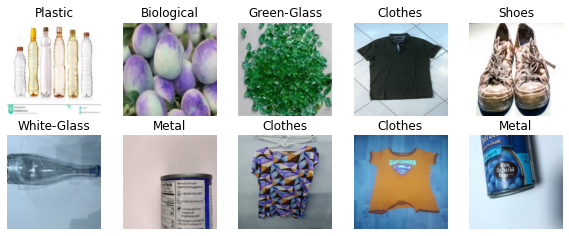

In [7]:
visualizeation_img(x, labels, 10)

In [8]:
def CNN_data_preparation():
  train = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1,
                             rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
  test = ImageDataGenerator(rescale=1/255, validation_split=0.1)
  train_generator = train.flow_from_directory(directory=dir_path,
                                              target_size=(target_size),
                                              class_mode="categorical",
                                              subset="training")
  test_generator = test.flow_from_directory(directory=dir_path,
                                            target_size=(target_size),
                                            batch_size=251,
                                            class_mode="categorical",
                                            subset="validation")
  return train_generator, test_generator

In [9]:
train_generator, test_generator = CNN_data_preparation()

Found 13970 images belonging to 12 classes.
Found 1545 images belonging to 12 classes.


# Modeling

In [20]:
def CNN_create_and_fit_model(train_generator, test_generator, summary=True, fit=True, epochs=100):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Flatten())

  model.add(Dense(units=64, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=32, activation="relu"))
  model.add(Dropout(rate=0.2))

  model.add(Dense(units=12, activation="softmax"))

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

  callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
              ModelCheckpoint(filepath="mymodel.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
  if summary:
    model.summary()
  
  if fit:
    history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=test_generator, 
                                callbacks=callbacks, workers=4, steps_per_epoch=437, validation_steps=1545//32) # steps_per_epoch=2276//32, validation_steps=251//32
                                                                                                              # you can choose 2276/32 is 71 per epoch for best accuracy

  return model, history

In [ ]:
model, history = CNN_create_and_fit_model(train_generator, test_generator)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)            

# Evaluation

In [12]:
def CNN_model_evaluate(model):
  loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
  print("Test Accuracy: %.2f" % (100 * acc))
  print("Test Loss: %.2f" % (100 * loss))
  print("Test Precision: %.2f" % (100 * precision))
  print("Test Recall: %.2f" % (100 * recall))

  X_test, y_test = test_generator.next()
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(y_test, axis=1)
  target_names = list(waste_labels.keys())
  print(classification_report(y_test, y_pred, target_names=target_names))

  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  plt.plot(history.history["acc"], color="r", label="Training Accuracy")
  plt.plot(history.history["val_acc"], color="b", label="Validation Accuracy")
  plt.legend(loc="lower right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Accuracy", fontsize=16)
  plt.ylim([min(plt.ylim()),1])
  plt.title("Training and Validation Accuracy", fontsize=16)

  plt.subplot(1,2,2)
  plt.plot(history.history["loss"], color="r", label="Training Loss")
  plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epoch", fontsize=16)
  plt.ylabel("Loss", fontsize=16)
  plt.ylim([0, max(plt.ylim())])
  plt.title("Training and Validation Loss", fontsize=16)

  return y_test, y_pred

In [13]:
y_test, y_pred = CNN_model_evaluate(model)

NameError: name 'model' is not defined

# Confusion Matrix

In [ ]:
cm = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  
  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True Labels", fontweight="bold")
  plt.xlabel("Predicted Labels", fontweight="bold")

In [ ]:
plot_confusion_matrix(cm, waste_labels.keys())

# Model Testing

In [ ]:
def CNN_model_testing(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [ ]:
img, p, predicted_class = CNN_model_testing("/content/drive/MyDrive/Colab Notebooks/datasets/Garbage classification/metal/metal100.jpg")

In [ ]:
waste_labels = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}
def plot_model_testing(img, p, predicted_class):
  plt.axis("off")
  plt.imshow(img.squeeze())
  plt.title("Maximum Probabilty: " + str(np.max(p[0], axis=-1)) + "\n" + "Predicted Class: " + str(waste_labels[predicted_class]))
  plt.imshow(img);

In [ ]:
plot_model_testing(img, p, predicted_class)